In [213]:
%reset -sf

from time import time
time_start = time()

import pandas as pd
import numpy as np
import scipy as sp
import gc
import os
from matplotlib import pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' # suppress tensorflow imformation messages

from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import tensorflow as tf

import get_data as gd
import atlas_plot as ap
plot = ap.Plotter()

print(tf.__version__)
print(tf.config.list_physical_devices())
print()

2.13.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]



In [214]:
seed = 42  # set random seed
sampling = int(1e6)
# num_folds = 2
batch_size = 1024
epochs = 512
learning_rate = 1e-4

In [215]:
np.random.seed(seed)
processor = gd.DataProcessor(sampling=sampling, processor=10)
path = "/root/data/truth/signal/*npz"
processor.load_files(path)
data = gd.Data(*processor.files)
# print(dir(data))

Number of available processors: 128
Number of used processors: 10

['/root/data/truth/signal/CGLMP.npz', '/root/data/truth/signal/Higgs.npz', '/root/data/truth/signal/LeadLepton.npz', '/root/data/truth/signal/LeptonM.npz', '/root/data/truth/signal/LeptonP.npz', '/root/data/truth/signal/LmNu.npz', '/root/data/truth/signal/LpNu.npz', '/root/data/truth/signal/MET.npz', '/root/data/truth/signal/WmBoson.npz', '/root/data/truth/signal/WpBoson.npz', '/root/data/truth/signal/diLepton.npz', '/root/data/truth/signal/subLeadLepton.npz', '/root/data/truth/signal/xi_xyz.npz']



In [216]:
GEV = 1e3

cut_pre_pt_lead = data.LeadLep["pt"] > 22 * GEV
cut_pre_pt_sub = data.SubLep["pt"] > 15 * GEV
cut_pre_dilep_m = data.diLep["m"] > 10 * GEV
cut_pre_pt_miss = data.MET["pt"] > 20 * GEV
cut_pre = cut_pre_pt_lead & cut_pre_pt_sub & cut_pre_dilep_m & cut_pre_pt_miss

del (cut_pre_pt_lead, cut_pre_pt_sub, cut_pre_dilep_m, cut_pre_pt_miss)

In [217]:
lep_p = processor.process_part(data.LepP).iloc[:, :4]
lep_p.columns = ["lep_p_" + col.lower() for col in lep_p.columns]
lep_m = processor.process_part(data.LepM).iloc[:, :4]
lep_m.columns = ["lep_m_" + col.lower() for col in lep_m.columns]
w_p = pd.DataFrame(data.Wp["m"])
w_p.columns = ["w_p_" + col.lower() for col in w_p.columns]
w_m = pd.DataFrame(data.Wm["m"])
w_m.columns = ["w_m_" + col.lower() for col in w_m.columns]
met = processor.process_MET(data.MET).iloc[:, 1:3]
met.columns = ["met_px", "met_py"]
mt = pd.DataFrame(
    {
        "mt": np.sqrt(
            np.sum(
                np.square(
                    processor.process_dipart(data.LepP, data.LepM)[["m", "px", "py"]]
                ),
                axis=1,
            )
        )
    }
)
pta = pd.DataFrame(
    {
        "pta": np.sqrt(
            np.square(lep_p["lep_p_px"])
            + np.square(lep_p["lep_p_py"])
            + np.square(lep_m["lep_m_px"])
            + np.square(lep_m["lep_m_py"])
            + np.square(met["met_px"])
            + np.square(met["met_py"])
        )
    }
)

# Sperate the two shell classes
threshold = 60 * GEV  # threshold for separating the two classes
p_sep = w_p["w_p_m"] >= threshold
m_sep = w_m["w_m_m"] >= threshold
mask1 = cut_pre & p_sep & ~m_sep
mask2 = cut_pre & ~p_sep & m_sep

obs_kin_1 = pd.concat([met, lep_p, lep_m, mt, pta], axis=1)[mask1]
obs_kin_2 = pd.concat([met, lep_p, lep_m, mt, pta], axis=1)[mask2]
print(type(obs_kin_1), type(obs_kin_2))
print("obs_kin shape:", obs_kin_1.shape, obs_kin_2.shape)
print(obs_kin_1.head(3), "\n", obs_kin_2.head(3))
print()

# int_kin_1 = pd.concat([w_p["w_p_m"], w_m["w_m_m"]], axis=1)[mask1]
# int_kin_2 = pd.concat([w_p["w_p_m"], w_m["w_m_m"]], axis=1)[mask2]
int_kin_1 = pd.concat([w_p["w_p_m"]], axis=1)[mask1]
int_kin_2 = pd.concat([w_p["w_p_m"]], axis=1)[mask2]
print(type(int_kin_1), type(int_kin_2))
print("int_kin shape:", int_kin_1.shape, int_kin_2.shape)
print(int_kin_1.head(3), "\n", int_kin_2.head(3))
print()

# del (processor, lep_p, lep_m, met, dilep_kin, mt, vx)
# gc.collect()

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>
obs_kin shape: (662396, 12) (663448, 12)
       met_px     met_py     lep_p_e   lep_p_px  lep_p_py    lep_p_pz  \
7   96.335650  47.095450   19.500895  -4.561588  18.92441   -1.154271   
9  -26.992604 -70.883859  164.814766  34.397141   2.03130 -161.172625   
21 -65.691990  34.546791  190.213375 -33.501133 -28.27757  185.092359   

       lep_m_e   lep_m_px   lep_m_py    lep_m_pz          mt         pta  
7    43.361348  42.407754  -4.632000    7.767462   62.513416  117.035693  
9    70.592648  29.001777   1.896990  -64.332027   67.559621   88.233289  
21  192.252422 -55.010402 -18.986748  183.233031  103.036364  104.007241   
        met_px     met_py    lep_p_e   lep_p_px   lep_p_py   lep_p_pz  \
10  44.222846 -15.383637  47.669113 -26.605045 -17.256748  35.590859   
13 -35.807631   4.480668  52.595516  12.459787   9.784288  50.152863   
18   8.478388 -54.210879  31.746979  14.220096   8.616839 -27.044379   


In [218]:
# plt.hist(w_p["w_p_m"]/GEV, bins=200, alpha=.8)
# plt.title(r"$m_{W^+}$")
# plt.xlabel("mass [GeV]")
# plt.ylabel("count")
# # plt.xlim([0,200])
# plt.show()
# plt.hist(w_m["w_m_m"]/GEV, bins=200, alpha=.8)
# plt.title(r"$m_{W^-}$")
# plt.xlabel("mass [GeV]")
# plt.ylabel("count")
# # plt.xlim([0,200])
# plt.show()

In [219]:
# plt.hist(int_kin_1["w_p_m"] / GEV, bins=100, alpha=0.8)
# plt.title(r"$m_{W^+}$ on-shell")
# plt.xlabel("mass [GeV]")
# plt.ylabel("count")
# plt.show()

# plt.hist(int_kin_1["w_m_m"] / GEV, bins=100, alpha=0.8)
# plt.title(r"$m_{W^-}$ off-shell")
# plt.xlabel("mass [GeV]")
# plt.ylabel("count")
# plt.show()

In [220]:
# plt.hist(int_kin_2["w_p_m"] / GEV, bins=100, alpha=0.8)
# plt.title(r"$m_{W^+}$ off-shell")
# plt.xlabel("mass [GeV]")
# plt.ylabel("count")
# plt.show()

# plt.hist(int_kin_2["w_m_m"] / GEV, bins=100, alpha=0.8)
# plt.title(r"$m_{W^-}$ on-shell")
# plt.xlabel("mass [GeV]")
# plt.ylabel("count")
# plt.show()

In [221]:
SCALAR_int_ru = RobustScaler()
int_kin_1 = SCALAR_int_ru.fit_transform(int_kin_1)
# SCALAR_int_mm = MinMaxScaler(feature_range=(0, 1))
# int_kin_1 = SCALAR_int_mm.fit_transform(int_kin_1)

SCALAR_obs_ru = RobustScaler()
obs_kin_1 = SCALAR_obs_ru.fit_transform(obs_kin_1)
# SCALAR_obs_mm = MinMaxScaler(feature_range=(0, 1))
# obs_kin_1 = SCALAR_obs_mm.fit_transform(obs_kin_1)

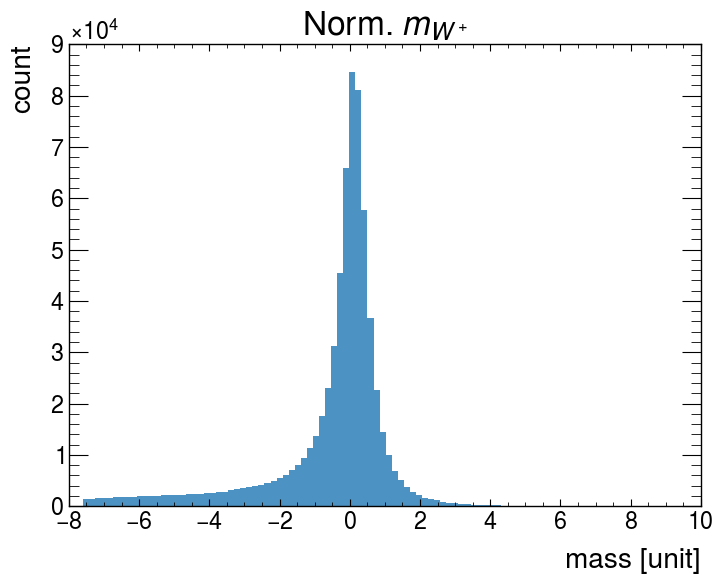

In [222]:
plt.hist(int_kin_1[:, 0], bins=100, alpha=.8)
plt.title("Norm." + r" $m_{W^+}$")
plt.xlabel("mass [unit]")
plt.ylabel("count")
# plt.xlim([0,800])
plt.show()
# plt.hist(int_kin_1[:, 1], bins=100, alpha=.8)
# plt.title("Norm." + r" $m_{W^-}$")
# plt.xlabel("mass [unit]")
# plt.ylabel("count")
# # plt.xlim([0,800])
# plt.show()

In [223]:
indices_arr = np.arange(int_kin_1.shape[0], dtype="int")
train_indices, temp_indices = train_test_split(
    indices_arr.flatten(),
    train_size=0.4,
    test_size=0.6,
    random_state=seed,
    shuffle=True,
)
valid_indices, test_indices = train_test_split(
    temp_indices, train_size=0.5, test_size=0.5, random_state=42
)

train_x = obs_kin_1[train_indices]
test_x = obs_kin_1[test_indices]
valid_x = obs_kin_1[valid_indices]
train_y = int_kin_1[train_indices]
test_y = int_kin_1[test_indices]
valid_y = int_kin_1[valid_indices]

print(
    f"X (Interest)\nTraining data shape: {train_x.shape};\nValiding data shape: {valid_x.shape};\nTesting data shape: {test_x.shape}."
)
print(
    f"Y (Observed)\nTraining data shape: {train_y.shape};\nValiding data shape: {valid_y.shape};\nTesting data shape: {test_y.shape}."
)
print()

X (Interest)
Training data shape: (264958, 12);
Validing data shape: (198719, 12);
Testing data shape: (198719, 12).
Y (Observed)
Training data shape: (264958, 1);
Validing data shape: (198719, 1);
Testing data shape: (198719, 1).



In [231]:
# Define a new activation function
def custom_activation(x):
    return x*tf.keras.backend.sigmoid(x)

# Define the model.
def build_model():
    # Input layer
    inputs = tf.keras.layers.Input(shape=(train_x.shape[-1],))
    x = tf.keras.layers.Flatten()(inputs)

    # Hidden tf.keras.layers
    x = tf.keras.layers.Dense(units=2048, activation="elu")(x)
    x = tf.keras.layers.Dense(units=2048, activation="elu")(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(rate=0.2)(x)
    x = tf.keras.layers.Dense(units=128, activation="elu")(x)
    x = tf.keras.layers.Dense(units=128, activation="elu")(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.Dropout(rate=0.1)(x)
    # x = tf.keras.layers.Dense(units=16, activation="elu")(x)
    # x = tf.keras.layers.Dense(units=16, activation="elu")(x)

    # Last dense layer
    outputs = tf.keras.layers.Dense(units=train_y.shape[-1], activation="linear")(x)

    # Compile model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss="mse",
    )

    # Summarize the model
    model.summary()

    return model

In [232]:
model = build_model()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 12)]              0         
                                                                 
 flatten_14 (Flatten)        (None, 12)                0         
                                                                 
 dense_90 (Dense)            (None, 2048)              26624     
                                                                 
 dense_91 (Dense)            (None, 2048)              4196352   
                                                                 
 dropout_15 (Dropout)        (None, 2048)              0         
                                                                 
 dense_92 (Dense)            (None, 128)               262272    
                                                                 
 dense_93 (Dense)            (None, 128)               165

_________________________________________________________________


In [233]:
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1e-6,
    patience=10,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

# Fit the model
history = model.fit(
    x=train_x,
    y=train_y,
    validation_data=(valid_x, valid_y),
    epochs=epochs,
    batch_size=batch_size,
    verbose=2,
    callbacks=[stop_early],
)

Epoch 1/512


259/259 - 3s - loss: 2.8123 - val_loss: 2.7317 - 3s/epoch - 10ms/step
Epoch 2/512
259/259 - 1s - loss: 2.7196 - val_loss: 2.7177 - 1s/epoch - 5ms/step
Epoch 3/512
259/259 - 1s - loss: 2.7038 - val_loss: 2.6950 - 1s/epoch - 5ms/step
Epoch 4/512
259/259 - 1s - loss: 2.6982 - val_loss: 2.6893 - 1s/epoch - 5ms/step
Epoch 5/512
259/259 - 1s - loss: 2.6906 - val_loss: 2.6933 - 1s/epoch - 5ms/step
Epoch 6/512
259/259 - 1s - loss: 2.6861 - val_loss: 2.6846 - 1s/epoch - 5ms/step
Epoch 7/512
259/259 - 1s - loss: 2.6798 - val_loss: 2.6801 - 1s/epoch - 5ms/step
Epoch 8/512
259/259 - 1s - loss: 2.6762 - val_loss: 2.6751 - 1s/epoch - 5ms/step
Epoch 9/512
259/259 - 1s - loss: 2.6708 - val_loss: 2.6699 - 1s/epoch - 5ms/step
Epoch 10/512
259/259 - 1s - loss: 2.6678 - val_loss: 2.6661 - 1s/epoch - 5ms/step
Epoch 11/512
259/259 - 1s - loss: 2.6631 - val_loss: 2.6641 - 1s/epoch - 5ms/step
Epoch 12/512
259/259 - 1s - loss: 2.6586 - val_loss: 2.6658 - 1s/epoch - 5ms/step
Epoch 13/512
259/259 - 1s - loss: 2.

In [234]:
# save model
model.save("DNN_w_seperated.h5", save_format="h5", overwrite=True)
# predict
pred_y = model.predict(test_x)
sig_pred = pred_y
sig_truth = test_y

/root/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6210/6210 [==============================] - 7s 1ms/step


In [235]:
print(f"Truth mean: {np.mean(sig_truth[:,0]):.3f}, std: {np.std(sig_truth[:,0]):.3f}, min: {np.min(sig_truth[:,0]):.3f}, max: {np.max(sig_truth[:,0]):.3f}")

Truth mean: -0.486, std: 1.701, min: -7.608, max: 9.643


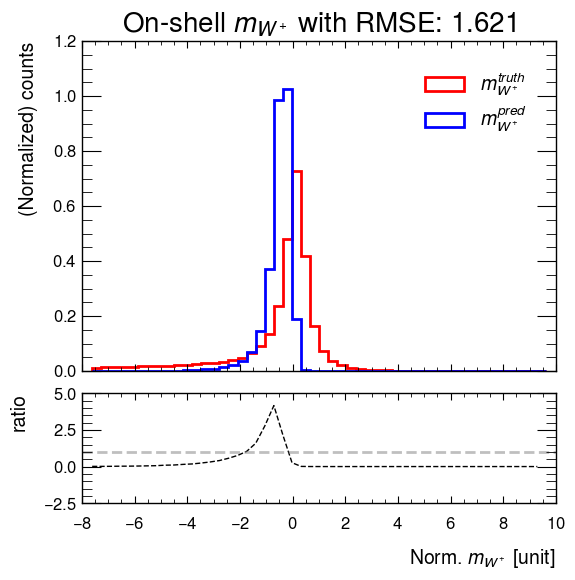

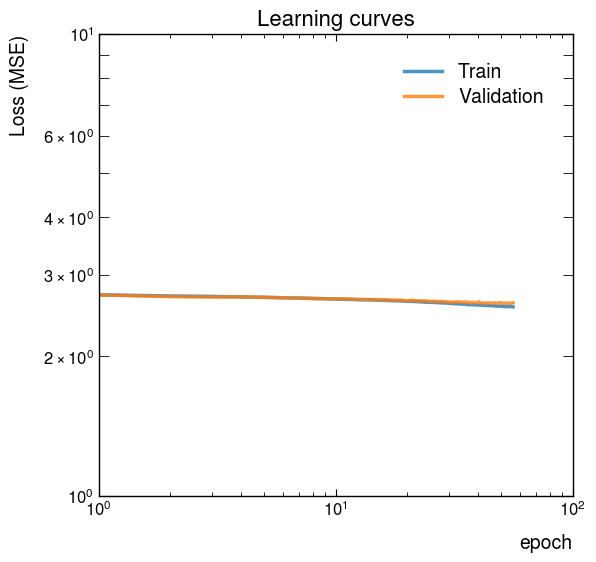

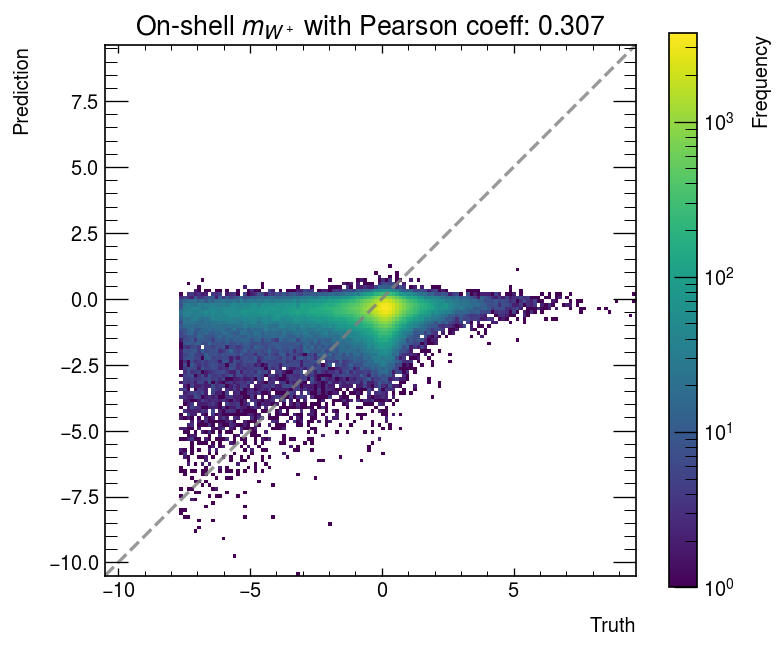

In [236]:
range = [0, 1]

plot.plot_hist(
    [sig_truth[:, 0], sig_pred[:, 0]],
    [r"$m^{truth}_{W^+}$", r"$m^{pred}_{W^+}$"],
    r"On-shell $m_{W^+}$"
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth[:,0], sig_pred[:,0])):.3f}",
    xlabel=r"Norm. $m_{W^+}$ [unit]",
    # range=range,
)

# plot.plot_hist(
#     [sig_truth[:, 1], sig_pred[:, 1]],
#     [r"$m^{truth}_{W^-}$", r"$m^{pred}_{W^-}$"],
#     r"Off-shell $m_{W^-}$"
#     + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth[:,0], sig_pred[:,0])):.3f}",
#     xlabel=r"Norm. $m_{W^-}$ [unit]",
#     range=range,
# )

plot.plot_loss_history(history, logx=True, logy=True)

plot.plot_2d_histogram(
    sig_truth[:, 0],
    sig_pred[:, 0],
    r"On-shell $m_{W^+}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(sig_truth[:,0], sig_pred[:,0])[0]:.3f}",
    # range=range,
)
# plot.plot_2d_histogram(
#     sig_truth[:, 1],
#     sig_pred[:, 1],
#     r"Off-shell $m_{W^-}$ "
#     + f"with Pearson coeff: {sp.stats.pearsonr(sig_truth[:,1], sig_pred[:,1])[0]:.3f}",
#     range=range,
# )